# Inference on real Hyperfine data

In [1]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *

## Initialization

### Load models and dataloader

In [2]:
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',100)
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',100)
brats_train_loader, brats_test_loader, brats_val_loader = get_dataloader('brats',100)

model_vae_dhcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-dhcp-1550.pth')
model_vae_hcp = load_model('/media/hdd/viscent/create-models/20220706/vae_hcp/91.pth')
model_vae_dhcp.augmentation = False
model_vae_hcp.augmentation = False
model_vae_hcp.recon_loss = 'mse'
model_vae_dhcp.eval()
model_vae_hcp.eval()

[09/05/22 17:16:17] INFO     colossalai - root - INFO: Creating dataset with 80 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 80

  0%|          | 0/80 [00:00<?, ?it/s]

[09/05/22 17:16:21] INFO     colossalai - root - INFO: Creating dataset with 20 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 20

  0%|          | 0/20 [00:00<?, ?it/s]

                    INFO     colossalai - root - INFO: Creating dataset with 80 examples

  0%|          | 0/80 [00:00<?, ?it/s]

[09/05/22 17:16:23] INFO     colossalai - root - INFO: Creating dataset with 20 examples

  0%|          | 0/20 [00:00<?, ?it/s]

                    INFO     colossalai - root - INFO: Creating dataset with 80 examples

  0%|          | 0/80 [00:00<?, ?it/s]

[09/05/22 17:16:26] INFO     colossalai - root - INFO: Creating dataset with 20 examples

  0%|          | 0/20 [00:00<?, ?it/s]

BUNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(1, 8, eps=1e-05, affine=True)
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
       

### Generate/Load priori

In [ ]:
mu_dhcp_dhcp = []
mu_dhcp_hcp = []
mu_hcp_dhcp = []
mu_hcp_hcp = []

logvar_dhcp_dhcp = []
logvar_dhcp_hcp = []
logvar_hcp_dhcp = []
logvar_hcp_hcp = []

model_vae_dhcp.train()
model_vae_hcp.train()

for im, gt in tqdm(dhcp_val_loader):
    im = im.cuda()
    gt = gt.cuda()
    output_dhcp = model_vae_dhcp(im)
    output_hcp = model_vae_hcp(im)    
    model_vae_dhcp.VAE_loss(output_dhcp,gt)
    model_vae_hcp.VAE_loss(output_hcp,gt)
    mu_dhcp_dhcp.append(model_vae_dhcp.enc_mu.cpu().detach())
    mu_hcp_dhcp.append(model_vae_hcp.enc_mu.cpu().detach())
    logvar_dhcp_dhcp.append(model_vae_dhcp.enc_logvar.cpu().detach())
    logvar_hcp_dhcp.append(model_vae_hcp.enc_logvar.cpu().detach())
for im, gt in tqdm(hcp_val_loader):
    im = im.cuda()
    gt = gt.cuda()
    output_dhcp = model_vae_dhcp(im)
    output_hcp = model_vae_hcp(im)
    model_vae_dhcp.VAE_loss(output_dhcp,gt)
    model_vae_hcp.VAE_loss(output_hcp,gt)
    mu_dhcp_hcp.append(model_vae_dhcp.enc_mu.cpu().detach())
    mu_hcp_hcp.append(model_vae_hcp.enc_mu.cpu().detach())
    logvar_dhcp_hcp.append(model_vae_dhcp.enc_logvar.cpu().detach())
    logvar_hcp_hcp.append(model_vae_hcp.enc_logvar.cpu().detach())



# mu_dhcp_dhcp = torch.stack(mu_dhcp_dhcp).cpu().numpy().mean(axis=1)
# mu_dhcp_hcp = torch.stack(mu_dhcp_hcp).cpu().numpy().mean(axis=1)
# mu_dhcp_brats = torch.stack(mu_dhcp_brats).cpu().numpy().mean(axis=1)
# mu_hcp_dhcp = torch.stack(mu_hcp_dhcp).cpu().numpy().mean(axis=1)
# mu_hcp_hcp = torch.stack(mu_hcp_hcp).cpu().numpy().mean(axis=1)
# mu_hcp_brats = torch.stack(mu_hcp_brats).cpu().numpy().mean(axis=1)

# logvar_dhcp_dhcp = torch.stack(logvar_dhcp_dhcp).cpu().numpy().mean(axis=1)
# logvar_dhcp_hcp = torch.stack(logvar_dhcp_hcp).cpu().numpy().mean(axis=1)
# logvar_dhcp_brats = torch.stack(logvar_dhcp_brats).cpu().numpy().mean(axis=1)
# logvar_hcp_dhcp = torch.stack(logvar_hcp_dhcp).cpu().numpy().mean(axis=1)
# logvar_hcp_hcp = torch.stack(logvar_hcp_hcp).cpu().numpy().mean(axis=1)
# logvar_hcp_brats = torch.stack(logvar_hcp_brats).cpu().numpy().mean(axis=1)


mu_dhcp_dhcp = torch.stack(mu_dhcp_dhcp)
mu_dhcp_hcp = torch.stack(mu_dhcp_hcp)
mu_hcp_dhcp = torch.stack(mu_hcp_dhcp)
mu_hcp_hcp = torch.stack(mu_hcp_hcp)

logvar_dhcp_dhcp = torch.stack(logvar_dhcp_dhcp)
logvar_dhcp_hcp = torch.stack(logvar_dhcp_hcp)
logvar_hcp_dhcp = torch.stack(logvar_hcp_dhcp)
logvar_hcp_hcp = torch.stack(logvar_hcp_hcp)

torch.save(mu_dhcp_dhcp, '/media/hdd/viscent/SR-UNet/results/mu_dhcp_dhcp.pt')
torch.save(mu_dhcp_hcp, '/media/hdd/viscent/SR-UNet/results/mu_dhcp_hcp.pt')
torch.save(mu_hcp_dhcp, '/media/hdd/viscent/SR-UNet/results/mu_hcp_dhcp.pt')
torch.save(mu_hcp_hcp, '/media/hdd/viscent/SR-UNet/results/mu_hcp_hcp.pt')

torch.save(logvar_dhcp_dhcp, '/media/hdd/viscent/SR-UNet/results/logvar_dhcp_dhcp.pt')
torch.save(logvar_dhcp_hcp, '/media/hdd/viscent/SR-UNet/results/logvar_dhcp_hcp.pt')
torch.save(logvar_hcp_dhcp, '/media/hdd/viscent/SR-UNet/results/logvar_hcp_dhcp.pt')
torch.save(logvar_hcp_hcp, '/media/hdd/viscent/SR-UNet/results/logvar_hcp_hcp.pt')

In [3]:
mu_dhcp_dhcp = torch.load('/media/hdd/viscent/SR-UNet/results/mu_dhcp_dhcp.pt')
mu_dhcp_hcp = torch.load('/media/hdd/viscent/SR-UNet/results/mu_dhcp_hcp.pt')
mu_hcp_dhcp = torch.load('/media/hdd/viscent/SR-UNet/results/mu_hcp_dhcp.pt')
mu_hcp_hcp = torch.load('/media/hdd/viscent/SR-UNet/results/mu_hcp_hcp.pt')

logvar_dhcp_dhcp = torch.load('/media/hdd/viscent/SR-UNet/results/logvar_dhcp_dhcp.pt')
logvar_dhcp_hcp = torch.load('/media/hdd/viscent/SR-UNet/results/logvar_dhcp_hcp.pt')
logvar_hcp_dhcp = torch.load('/media/hdd/viscent/SR-UNet/results/logvar_hcp_dhcp.pt')
logvar_hcp_hcp = torch.load('/media/hdd/viscent/SR-UNet/results/logvar_hcp_hcp.pt')

mu_dhcp_dhcp = mu_dhcp_dhcp.cuda()
mu_dhcp_hcp = mu_dhcp_hcp.cuda()
mu_hcp_dhcp = mu_hcp_dhcp.cuda()
mu_hcp_hcp = mu_hcp_hcp.cuda()

logvar_dhcp_dhcp = logvar_dhcp_dhcp.cuda()
logvar_dhcp_hcp = logvar_dhcp_hcp.cuda()
logvar_hcp_dhcp = logvar_hcp_dhcp.cuda()
logvar_hcp_hcp = logvar_hcp_hcp.cuda()


In [8]:
model_vae_hcp = load_model('/media/hdd/viscent/create-models/20220706/vae_hcp/91.pth')
model_vae_hcp.augmentation = False
# model_vae_hcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/vae-hcp-last.pth')

In [ ]:
for image_tensor,_ in hcp_val_loader:
    print('---------------------------------')
    eval_tensor(image_tensor,model_vae_hcp,mu_hcp_hcp,logvar_hcp_hcp)
    print('---------------------------------')

## Adult Inference

The latest model is trained on aggresively augmented data, which is not optimal for our data. We are using 91st checkpoint of model trained on 6th of July.

Training data KLD = 1.7746e+31

In [45]:
def display_multiplanar_center(image,**kwargs):
    return display_multiplanar(image, x=image.shape[0]//2, y=image.shape[1]//2, z=image.shape[2]//2,**kwargs)

def eval_hyperfine(image_path: str, model, mu, logvar):
    image = sitk.ReadImage(image_path)
    image_tensor = torch.from_numpy(sitk.GetArrayFromImage(image))
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0).float().cuda()
    with torch.no_grad():
        output_tensor = model(image_tensor).flip(2)
    image_tensor = image_tensor.flip(2)
    fig_in = display_multiplanar_center(image_tensor[0,0].cpu().numpy())
    fig_out = display_multiplanar_center(output_tensor[0,0].cpu().numpy())
    kl = kl_forward_prior(model,output_tensor,mu,logvar).cpu().detach()
    output_image = sitk.GetImageFromArray(output_tensor[0,0].cpu().numpy())
    return output_image, fig_in, fig_out, kl
def display_multiplanar(image, x=1, y=1, z=1, save_fig=False, save_path=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_facecolor('black')
    ax1.imshow(image[x,:,:], cmap=plt.cm.Greys_r)
    ax1.axis("off")
    ax2.imshow(image[:,y,:], cmap=plt.cm.Greys_r)
    ax2.axis("off")
    ax3.imshow(image[:,:,z], cmap=plt.cm.Greys_r)
    ax3.axis("off")
    plt.show(facecolor='black')
    if save_fig:
        fig.savefig(save_path)
    return fig
def display_multiplanar_color(image, x=1, y=1, z=1, save_fig=False, save_path=None):
    x=image.shape[0]//2
    y=image.shape[1]//2
    z=image.shape[2]//2
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(image[x,:,:], cmap='jet')
    ax1.axis("off")
    ax2.imshow(image[:,y,:], cmap='jet')
    ax2.axis("off")
    ax3.imshow(image[:,:,z], cmap='jet')
    ax3.axis("off")
    plt.show()
    return fig

-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/004.nii.gz------


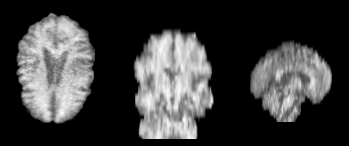

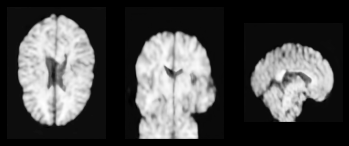

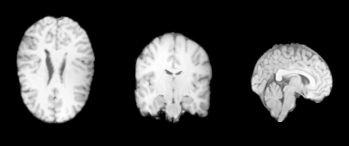

kl: 16361785133370306965339434385408.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/003.nii.gz------


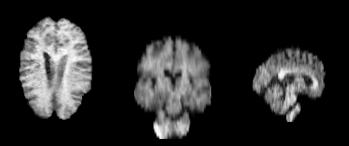

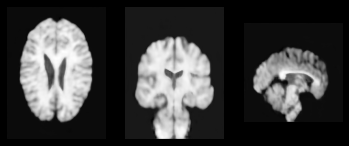

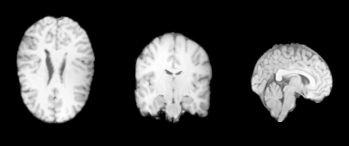

kl: 14038837440625642667313951932416.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/011.nii.gz------


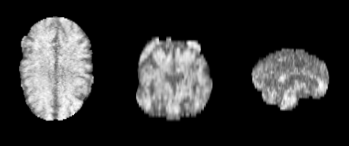

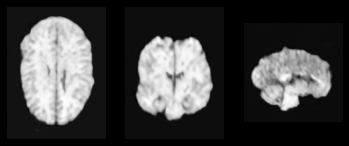

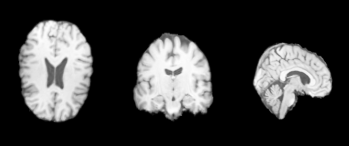

kl: 14251024207987677265681528651776.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/009.nii.gz------


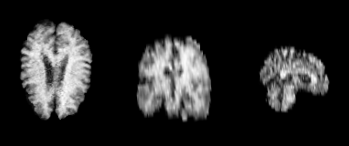

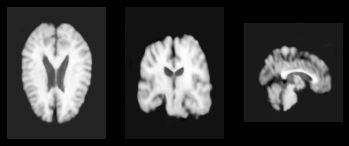

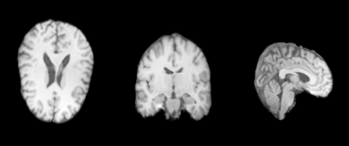

kl: 14083158085815066030222012841984.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/007.nii.gz------


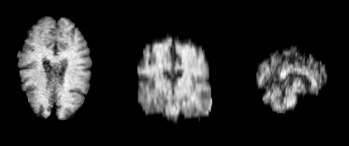

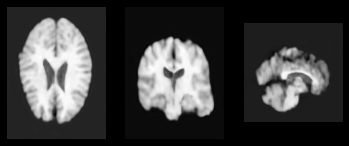

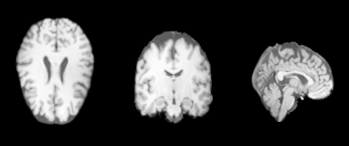

kl: 13949791959469635191954521194496.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/010.nii.gz------


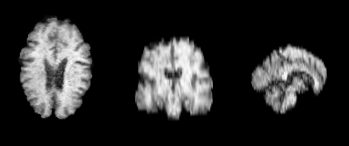

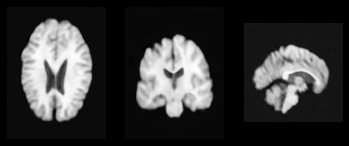

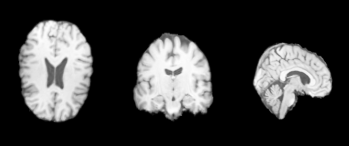

kl: 13763085953600879204693736161280.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/001.nii.gz------


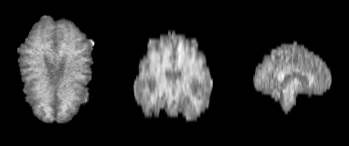

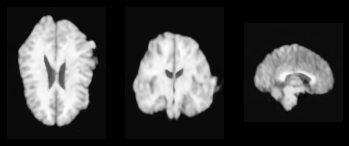

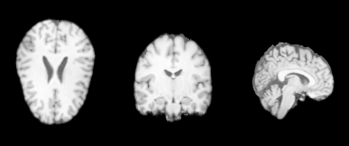

kl: 14464420366606311710194977996800.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/012.nii.gz------


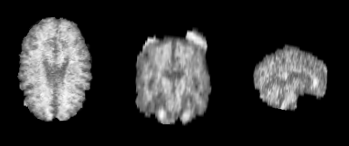

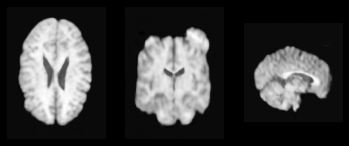

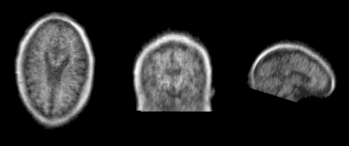

kl: 15378897028301067226161250041856.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/008.nii.gz------


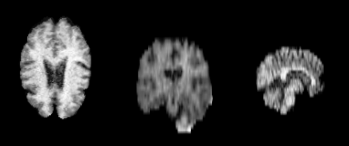

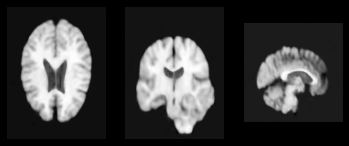

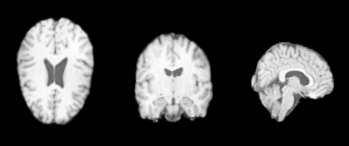

kl: 14094537910552476923744009322496.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/005.nii.gz------


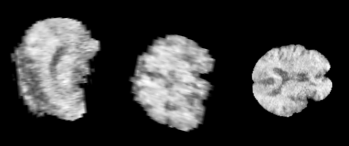

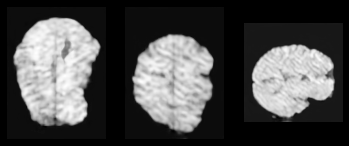

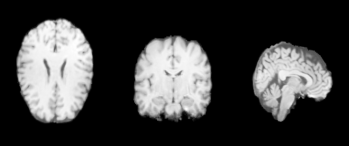

kl: 13877726319027974081584612507648.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/002.nii.gz------


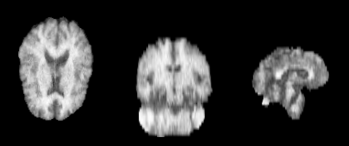

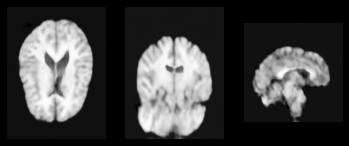

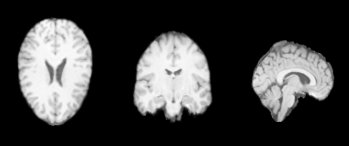

kl: 13782609032857034154794830266368.000000
---------------------------------
-----/media/hdd/viscent/inference_hyperfine/Brown/input_0706/006.nii.gz------


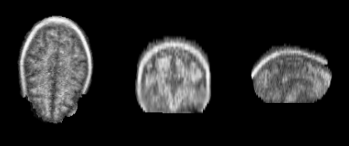

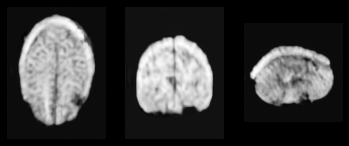

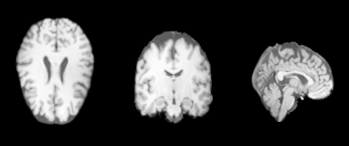

kl: 12391982455191900361203363348480.000000
---------------------------------


In [52]:
from glob import glob
from posixpath import basename
import shutil
input_root = '/media/hdd/viscent/inference_hyperfine/Brown/'
inputs = glob('/media/hdd/viscent/inference_hyperfine/Brown/input_0706/*.nii.gz')
saving_path = '/media/hdd/viscent/inference_hyperfine/Brown/output_bunet/'
kls = []
for input in inputs:
    subject = basename(input).split('.')[0]
    gt_image = sitk.ReadImage(os.path.join(input_root,'ground_truth',subject+'.nii.gz'))
    print('-----%s------'%input)
    output_image,fig_in,fig_out,kl = eval_hyperfine(input,model_vae_hcp,mu_hcp_hcp,logvar_hcp_hcp)
    shutil.copy(input,saving_path+subject+'_input.nii.gz')
    sitk.WriteImage(output_image,saving_path+subject+'_output.nii.gz')
    fig_in.savefig(saving_path+subject+'_input.png',facecolor='black')
    fig_out.savefig(saving_path+subject+'_output.png',facecolor='black')
    fig_gt = display_multiplanar_center(sitk.GetArrayFromImage(gt_image)[::-1,:,:])
    fig_gt.savefig(saving_path+subject+'_gt.png',facecolor='black')
    print('kl: %f'%kl)
    kls.append(kl)
    print('---------------------------------')

/tmp/ipykernel_1274312/4251421547.py:12: RuntimeWarning:

divide by zero encountered in true_divide



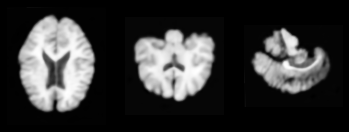

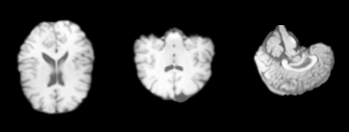

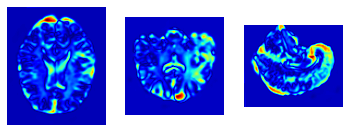

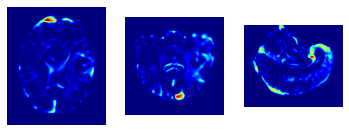

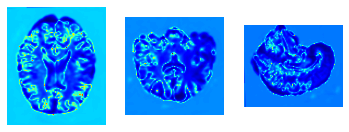

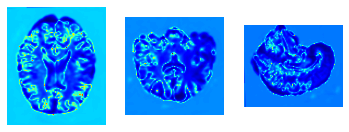

In [46]:
image_010,_ = load_image(mode='sitk',paths=['/media/hdd/viscent/inference_hyperfine/Brown/input_0706/010.nii.gz','/media/hdd/viscent/inference_hyperfine/Brown/input_0706/010.nii.gz'])
pred_010 = sitk.ReadImage('/home/viscent/hdd/viscent/hyperfine_t1_t2/ADULT_009/siemens/17122019/T1_pred_reg.nii.gz')
pred_010 = sitk.GetArrayFromImage(pred_010)
gt_010 = sitk.ReadImage('/home/viscent/hdd/viscent/hyperfine_t1_t2/ADULT_009/siemens/17122019/T1_reg.nii.gz')
gt_010 = sitk.GetArrayFromImage(gt_010)
pred_010 = (pred_010 - pred_010.min())/pred_010.std()
gt_010 = (gt_010-np.min(gt_010))/np.std(gt_010)


abse = np.abs(pred_010-gt_010)
mse = np.square(pred_010-gt_010)
psnr = 10*np.log10(1/mse)
display_multiplanar_center(pred_010)
display_multiplanar_center(gt_010)
display_multiplanar_color(abse)
display_multiplanar_color(mse)
display_multiplanar_color(psnr)

### Visualizing KL divergence distribution

The red line indicates the KL divergence of the training data.

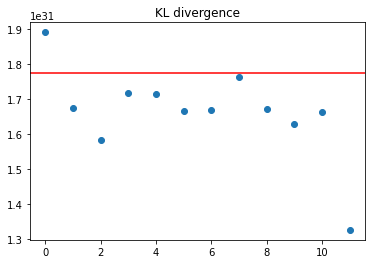

In [26]:
fig = plt.figure()
plt.title('KL divergence')
plt.scatter(range(len(kls)),kls)
plt.axhline(1.7746e+31, color='r', linestyle='-')

## dHCP Inference

The current implementation of brain extraction and registration is not optimal. Working on improving it.

---------------Training Data-----------------


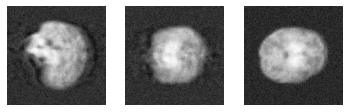

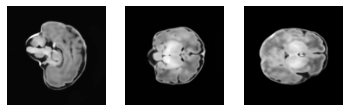

KL:  tensor(1.8193e+164, dtype=torch.float64)
---------------------------------------------


In [39]:
print('---------------Training Data-----------------')
image_tensor = dhcp_train_loader.__iter__().__next__()[0]
eval_tensor(image_tensor,model_vae_dhcp,mu_dhcp_dhcp,logvar_dhcp_dhcp)
print('---------------------------------------------')

---------------Paul Data-----------------


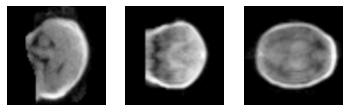

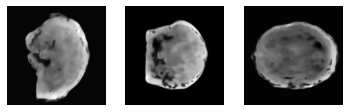

KL:  tensor(1.7336e+164, dtype=torch.float64)
-----------------------------------------


In [40]:
print('---------------Paul Data-----------------')
_,_,kl = eval_hyperfine('/media/hdd/viscent/inference_hyperfine/paul/HF00051_600_reg.nii.gz',model_vae_dhcp,mu_dhcp_dhcp,logvar_dhcp_dhcp)
print('-----------------------------------------')